# Project Data EDA

Our project goal is to predict the short term price movements during the 10 minute auction period. There are in total of 3 datasets. train, test and revealed_target. All the training data is contained within this single train.csv file, covering the timeframe from `date_id` [0,480]. The test dataset range from [478,480]. The reveal_target.csv file is one containing the true values, having the same time range with test file. 

Please refer to https://www.kaggle.com/competitions/optiver-trading-at-the-close/data & the introduction in this notebook for specific column definitions.

*   `stock_id` - A unique identifier for the stock. Not all stock IDs exist in every time bucket.
*   `date_id` - A unique identifier for the date. Date IDs are sequential & consistent across all stocks.
*   `seconds_in_bucket` - The number of seconds elapsed since the beginning of the day's closing auction, always starting from 0.
*   `imbalance_size` - The amount unmatched at the current reference price (in USD).
*   `imbalance_buy_sell_flag` - An indicator reflecting the direction of auction imbalance.
    * buy-side imbalance: 1
    * sell-side imbalance: -1
    * no imbalance: 0
*   `reference_price` - The price at which paired shares are maximized, the imbalance is minimized and the distance from the bid-ask midpoint is minimized, in that order. Can also be thought of as being equal to the near price bounded between the best bid and ask price.
*   `matched_size` - The amount that can be matched at the current reference price (in USD).
*   `far_price` - The crossing price that will maximize the number of shares matched based on auction interest only. This calculation excludes continuous market orders.
*   `near_price` - The crossing price that will maximize the number of shares matched based auction and continuous market orders.
*   `[bid/ask]_price` - Price of the most competitive buy/sell level in the non-auction book.
*   `[bid/ask]_size` - The dollar notional amount on the most competitive buy/sell level  in the non-auction book.
*   `wap` - The weighted average price in the non-auction book. $$\frac{ {BidPrice * AskSize + AskPrice * BidSize}}{BidSize + AskSize} $$
*   `target` - The 60 second future move in the wap of the stock, less the 60 second future move of the synthetic index.
    * The synthetic index is a custom weighted index of Nasdaq-listed stocks constructed by Optiver for this competition.
    * The unit of the target is basis points, which is a common unit of measurement in financial markets. A 1 basis point price move is equivalent to a  0.01% price move.
    * Where t is the time at the current observation, we can define the target:
$$ Target = (\frac{StockWAP_{t+60}}{StockWAP_{t}} - \frac{IndexWAP_{t+60}}{IndexWAP_{t}}) * 10000 $$

**All size related columns are in USD terms.**

**All price related columns are converted to a price move relative to the stock wap (weighted average price) at the beginning of the auction period.**

In [21]:
import pandas as pd
import numpy as np

In [35]:
# Dataset path
test_csv_path = 'test.csv'
train_csv_path = 'train.csv'
revealed_target_csv_path = 'revealed_targets.csv'

# Read the dataset
test_data = pd.read_csv(test_csv_path)
train_data = pd.read_csv(train_csv_path)
revealed_targets_data = pd.read_csv(revealed_target_csv_path)

## 1 Training dataset

### 1.1 Genral view

In [9]:
train_data.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


In [28]:
# Adjust display options
pd.set_option('display.float_format', lambda x: '%.3f' % x)  # Avoid scientific notation
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.width', 1000)  # Set the display width to utilize space

# Generate basic statistical summary for numeric features
train_numeric_summary = train_data.describe()

# Display basic statistical summary
print("Basic Statistical Summary for train dataset:")
print(train_numeric_summary)

Basic Statistical Summary for test dataset:
         stock_id     date_id  seconds_in_bucket  imbalance_size  imbalance_buy_sell_flag  reference_price   matched_size   far_price  near_price   bid_price     bid_size   ask_price     ask_size         wap      target     time_id
count 5237980.000 5237980.000        5237980.000     5237760.000              5237980.000      5237760.000    5237760.000 2343638.000 2380800.000 5237760.000  5237980.000 5237760.000  5237980.000 5237760.000 5237892.000 5237980.000
mean       99.289     241.510            270.000     5715293.099                   -0.012            1.000   45100245.284       1.002       1.000       1.000    51813.593       1.000    53575.683       1.000      -0.048   13310.052
std        57.872     138.532            158.745    20515906.297                    0.885            0.003  139841291.277       0.721       0.012       0.002   111421.406       0.003   129355.436       0.002       9.453    7619.271
min         0.000       0.00


`seconds_in_bucket`： represents time intervals in seconds, spans from 0 to 540, with an average midpoint value of 270 seconds. 

`imbalance_size` ： The substantial standard deviation observed suggests a significant disparity in trading imbalances, ranging from 0 to nearly 478.15 million, pointing to occasional extreme imbalances within the dataset.

`imbalance_buy_sell_flag`：a categorical variable taking values of -1, 0, and 1. A mean value of -0.012 hints at a slight inclination towards sell orders, and the standard deviation indicates a tendency for the data to be distributed at the variable's extremities.

`Reference_price` maintains a stable average at 1.000 with minimal standard deviation, signifying consistent reference prices throughout the dataset.

`matched_size`： exhibits a broad spectrum, from a minimal 4,316 to a substantial 7.71 billion, reflecting a high variability in the volume of trades.

`far_price`： with data for only 14,771 instances, has an average slightly below 1, at 0.9982, accompanied by a standard deviation that underscores potential price volatility.

`far_price` and `near_price`:  far fewer data points, about 235 millions.

The average of `bid_price` and `ask_price` are both at 1.00, But the maximum and minimum value of `ask_price` is slightly larger than those of `bid_price`. This differential establishes the typical bid-ask spread. The low standard deviations for both prices indicate minimal fluctuation from their respective means.

Both `bid_size` and `ask_size` demonstrate a pronounced variability relative to their mean values, as evidenced by their substantial standard deviations, indicating a wide variation in the quantity of bids and asks.

`weighted average price (WAP)` closely aligns with the reference price, with an average that nearly mirrors the 1.000 mark, suggesting that WAP is a reliable indicator of the reference price.

In summation, the dataset reveals a vast array of trading activities, with certain stocks and timeframes exhibiting notable volatility while others maintain stability. Despite the generally narrow bid-ask spread, the volume of trades demonstrates considerable diversity. This two-day data collection offers a glimpse into the short-term market dynamics.


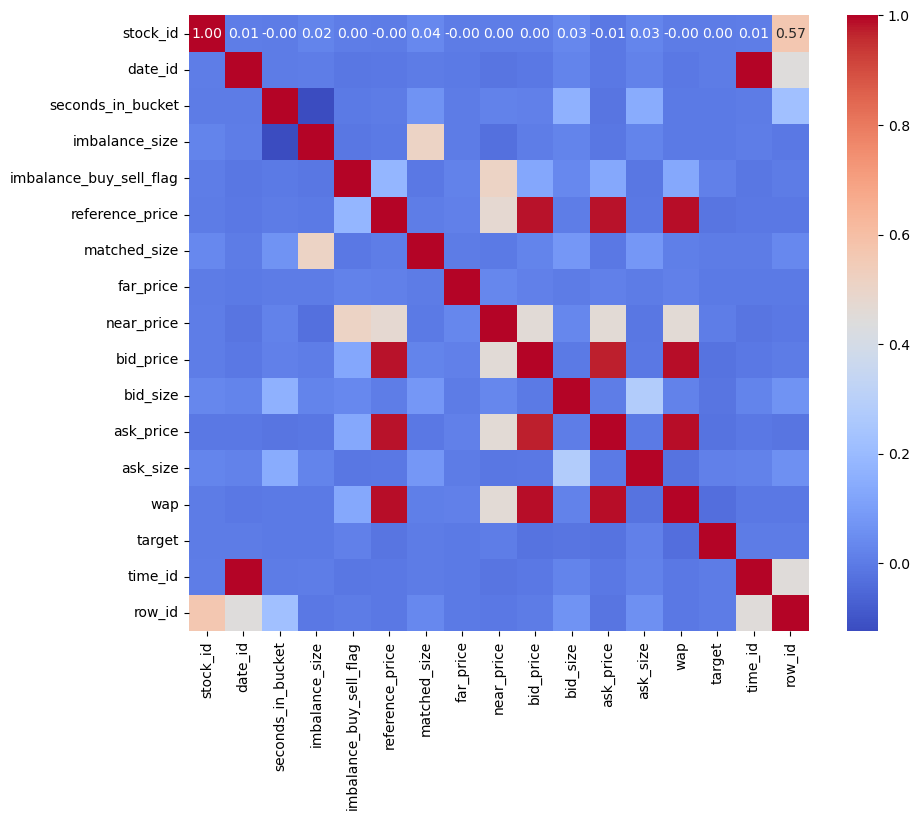

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt  # Import matplotlib for setting figure size

# Calculate the correlation matrix
corr_matrix = train_data.corr()

# Set the size of the matplotlib canvas
plt.figure(figsize=(10, 8))  # The figsize=(width, height) in inches

# Draw the heatmap 
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Save the figure 
heatmap.get_figure().savefig('heatmap.png')

 `bid price`and `ask_price` have a near-perfect correlation, as indicated by the deep red color, which is expected because these prices often move in tandem in financial markets.`bid_price` and `wap` also show a very high correlation, suggesting that the bid price strongly influences the weighted average price.`ask_price` and `wap` have a similarly high correlation,  emphasizing the strong influence of ask price on the weighted average price.`bid_size` and `ask_size` have a strong correlation, indicating that when the size of bids increases, the size of asks tends to increase as well, which could suggest balanced market activity.

`seconds_in_bucket` shows a moderate correlation with `matched_size`, implies that as time progresses, the volume of matched trades increases.`far_price` shows a moderate correlation with `near_price`, which is expected as these are different aspects of pricing in the order book.

Many pairs of variables, such as `imbalance_size` with `wap`, shows a very low to no correlation, which is represented by lighter colors or white. This indicates that changes in one variable do not linearly relate to changes in the other.

The high correlation between bid and ask prices, as well as their individual correlations with the weighted average price, underscores their significance in the pricing mechanism of the stock market.The correlation between `seconds_in_bucket` and `matched_size` might indicate a buildup of trading activity as the auction progresses.


In [29]:
train_data.isna().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

### 1.2. Bid_price, Ask_price

Ask price and bid price are with highly similar path, but with ask_price lying above the bid price. This indicate the typical bid-ask spread in the market.

<Axes: title={'center': 'Stock 0 on Day 0 - How the order book pricing changes during the auction'}, xlabel='seconds_in_bucket'>

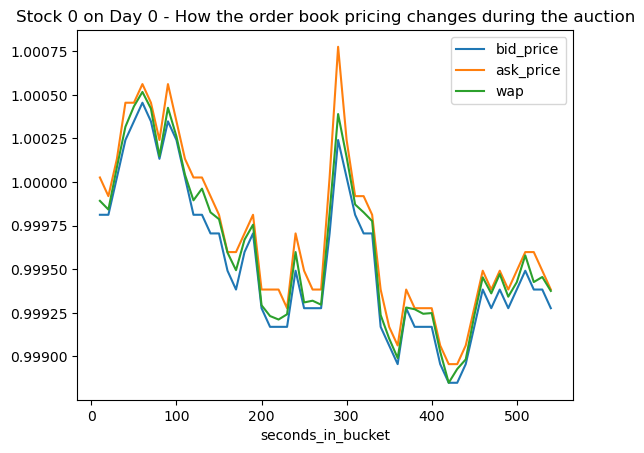

In [22]:
(
    train_data
    .query('stock_id ==0 & date_id ==0')
    [['seconds_in_bucket','bid_price','ask_price', 'wap']]
    .replace(0, np.nan)
    .set_index('seconds_in_bucket')
    .plot(title='Stock 0 on Day 0 - How the order book pricing changes during the auction')
)


### 1.3. Near_price, Far_price

The far_price and near_price appear periodically. Let us have a look at these two columns. We can conclude from the graph below that they come into play starting from `second_in_bucket` = 300.

In [17]:
train_data[['far_price', 'near_price']].describe()

,far_price,near_price
count,2.343638e+06,2.380800e+06
mean,1.001713e+00,9.996601e-01
std,7.214705e-01,1.216920e-02
min,7.700000e-05,7.869880e-01
25%,9.963320e-01,9.971000e-01
50%,9.998830e-01,9.998890e-01
75%,1.003318e+00,1.002590e+00
max,4.379531e+02,1.309732e+00


<Axes: title={'center': 'Stock 0 on Day 0 - How the auction & combined book pricing changes during the auction'}, xlabel='seconds_in_bucket'>

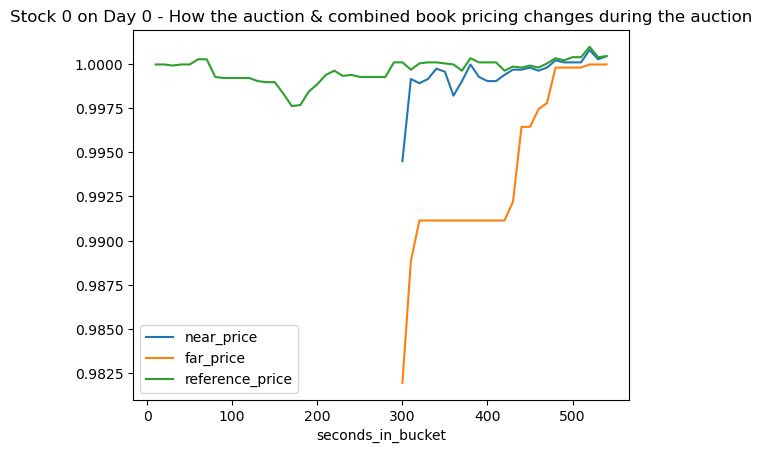

In [10]:
(
    train_data
    .query('stock_id ==1 & date_id ==0')
    [['seconds_in_bucket','near_price','far_price','reference_price']]
    .replace(0, np.nan)
    .set_index('seconds_in_bucket')
    .plot(title = 'Stock 0 on Day 0 - How the auction & combined book pricing changes during the auction')
)

Throughout the auction on Day 478 for Stock 0, the `reference_price`  exhibits minimal fluctuations, suggesting a consistent benchmark price that underpins the pricing structure during the auction.

The initial 300-second window features only the `reference_price` , implying a period dedicated to order submissions without active `near` and `far` price involvement. This phase likely sets the stage for subsequent price matching activities. Beyond the 300-second mark, the appearance of both `near_price` and `far_price` signals the start of vibrant trading. This period aligns with active price matching, where these prices become critical in the auction's pricing dynamics.

Subsequent to the 300-second threshold, `far_price` showcases marked volatility, characterized by a drastic decline and rebound. `near_price` experiences its own volatility, albeit less pronounced compared to `far_price`. This trend represent iterative adjustments as the market assimilates new orders and information.

As the auction progresses past the 400-second point, the convergence of `near` and `far` prices towards the `reference_price` could indicate the closing phase, where the market begins to settle and final transactions are executed.Approaching the end of the auction, the convergence of all price lines suggests a state of equilibrium. This could reflect a balanced market where `near` and `far` prices align closely with the `reference_price`, indicating an orderly market closure.

### 1.4. Imbalanced_size, Balanced_size

<Axes: title={'center': 'Stock 0 on Day 0 - How the auction sizing changes during the auction period'}, xlabel='seconds_in_bucket'>

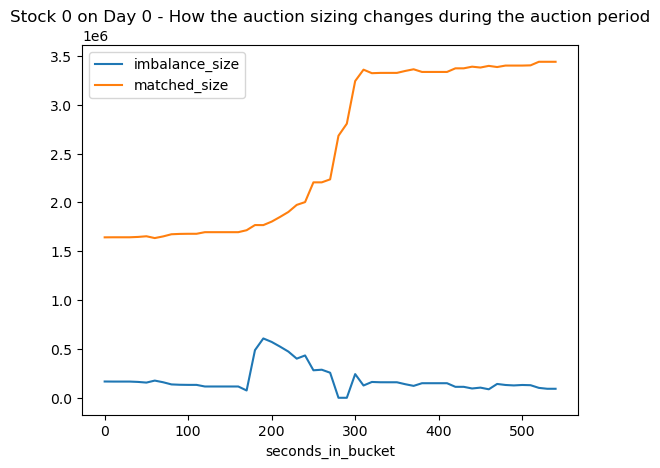

In [11]:
(
    train_data
    .query('stock_id ==1 & date_id ==0')
    [['seconds_in_bucket','imbalance_size','matched_size']]
    .set_index('seconds_in_bucket')
    .plot(title='Stock 0 on Day 0 - How the auction sizing changes during the auction period')
)

The `imbalance_size`  shows significant fluctuations during the auction period. Initially, there is a gradual increase, indicating a growing imbalance in the order book, which could signify a discrepancy between buy and sell orders. This is followed by a sharper rise, peaking around the 200-second mark, which reflects a large influx of either buy or sell orders not matched by the opposite side. After this peak, the `imbalance_size` decreases, suggesting a period of order matching that reduces the imbalance. The subsequent plateau indicates a relative stability in the imbalance size towards the end of the auction.

The `matched_size` remains relatively steady initially, with a slight increase. This suggests that trades are being executed at a consistent rate. A dramatic increase in `matched_size` occurs after the 300-second mark, which corresponds with a period of intense trading activity where a significant volume of orders is being matched. After this spike, the `matched_size` levels off, indicating that the pace of order matching has stabilized.

The sharp rise and subsequent plateau in `matched_size` after 300 seconds likely correspond to the price matching phase, where the auction mechanism is actively matching buy and sell orders.The peak in imbalance_size around the 200-second mark followed by a decrease could be indicative of market participants reacting to new information or price changes, leading to a flurry of order submissions that are then matched, as reflected in the increase in `matched_size`.The final stabilization of both imbalance_size and matched_size towards the end of the auction period suggests that the market has efficiently processed the orders, with most imbalances resolved and a significant volume of trades executed.


## 2. Testing data

In [36]:
test_data.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,time_id,row_id,currently_scored
0,0,478,0,3753451.430,-1,1.000,11548975.430,NaN,NaN,1.000,22940.000,1.000,9177.600,1.000,26290,478_0_0,False
1,1,478,0,985977.110,-1,1.000,3850033.970,NaN,NaN,1.000,1967.900,1.001,19692.000,1.000,26290,478_0_1,False
2,2,478,0,599128.740,1,1.001,4359198.250,NaN,NaN,1.000,4488.220,1.001,34955.120,1.000,26290,478_0_2,False
3,3,478,0,2872317.540,-1,1.000,27129551.640,NaN,NaN,1.000,16082.040,1.000,10314.000,1.000,26290,478_0_3,False
4,4,478,0,740059.140,-1,1.000,8880890.780,NaN,NaN,1.000,19012.350,1.000,7245.600,1.000,26290,478_0_4,False


In [39]:
test_data.groupby("date_id").size()

date_id
478    11000
479    11000
480    11000
dtype: int64

The test dataset is the same table structure with the train dataset, except the `date_id` starting from 478 and containing only 3-day data.

## 3. Revealed_target data

In [37]:
revealed_targets_data.head()

,stock_id,date_id,seconds_in_bucket,time_id,revealed_target,revealed_date_id,revealed_time_id
0,0.000,478,0,26290,-2.310,477.000,26235.000
1,1.000,478,0,26290,-12.850,477.000,26235.000
2,2.000,478,0,26290,-0.440,477.000,26235.000
3,3.000,478,0,26290,7.260,477.000,26235.000
4,4.000,478,0,26290,4.780,477.000,26235.000


In [41]:
revealed_targets_data.groupby("date_id").size()

date_id
478    11054
479    11054
480    11054
dtype: int64

In [42]:
# Generate basic statistical summary for numeric features
revealed_targets_numeric_summary = revealed_targets_data.describe()

# Display basic statistical summary
print("Basic Statistical Summary for test dataset:")
print(revealed_targets_numeric_summary)

Basic Statistical Summary for test dataset:
       stock_id   date_id  seconds_in_bucket   time_id  revealed_target  revealed_date_id  revealed_time_id
count 33000.000 33162.000          33162.000 33162.000        33000.000         33000.000         33000.000
mean     99.500   479.000            270.024 26345.134           -0.161           478.000         26317.000
std      57.735     0.817            158.734    44.962            8.031             0.817            47.631
min       0.000   478.000              0.000 26290.000         -144.380           477.000         26235.000
25%      49.750   478.000            130.000 26290.000           -3.920           477.000         26276.000
50%      99.500   479.000            270.000 26345.000           -0.140           478.000         26317.000
75%     149.250   480.000            410.000 26400.000            3.620           479.000         26358.000
max     199.000   480.000            540.000 26454.000           77.130           479.000   

The `revealed_target` column contains the real value of the column`target`, this is used for assessing the accuracy of the prediction results.